# Semantic Segmentation with Unet++

## Prepare

In [1]:
!pip install torchinfo
!pip install -U segmentation-models-pytorch
!pip install lungmask
!pip install openpyxl

     |████████████████████████████████| 97 kB 1.1 MB/s            
     |████████████████████████████████| 58 kB 2.8 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 376 kB 4.2 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c3b5ea4fd54398fd74b6dbf96ab7edf312ac7a74845cebf258142f85311065fa
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0d2602107b07407b32b7521568e52736b0b3cd55aa7fea9156145d3e3c25ab4c
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 1.1 MB 908 kB/s            
     |███████████████

In [2]:
import os
import json
import numpy as np
import pandas as pd
import nibabel as nib
# DL
import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import SimpleITK as sitk
from lungmask import mask as unet_mask
# Visualization
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import seaborn as sns

In [3]:
TGCOVID_PATH = "../input/tgcovid"
KAGGLECOVID_PATH = "../input/covid19-ct-scans"
MOSCOWCOVID_PATH = "../input/covid19moscow/COVID19_1110"

In [4]:
def expand_path(*right_part):
    def _expand_path(left_part):
        return os.path.join(*right_part, left_part) \
            if left_part is not np.nan else np.nan
    return _expand_path

def load_tgcovid_data(json_file):
    datapath = os.path.join(TGCOVID_PATH, "data", "data")
    path_images = os.path.join(datapath, 'images')
    path_labels = os.path.join(datapath, 'labels')
    with open(os.path.join(TGCOVID_PATH, json_file), 'r') as f:
        dict_data = json.load(f)

    data = pd.DataFrame(dict_data)
    # expand path to full
    data["image"] = data["image"].apply(expand_path(path_images))
    data["label"] = data["label"].apply(expand_path(path_labels))
    # remove .gz
    data["image"] = data["image"].str[:-3]
    data["label"] = data["label"].str[:-3]
    return data

def load_kagglecovid_data(csv_file):
    datapath = os.path.join(KAGGLECOVID_PATH, csv_file)
    data = pd.read_csv(datapath)
    data.rename(columns={"ct_scan":"image", "infection_mask":"label"}, inplace=True)
    data.drop("lung_and_infection_mask", inplace=True, axis=1)
    return data

def load_moscowcovid_data(xlsx_file):
    datapath = os.path.join(MOSCOWCOVID_PATH, xlsx_file)
    data = pd.read_excel(datapath)
    data.rename(columns={"study_file":"image", "mask_file":"label"}, inplace=True)
    data.drop(["category", "study_id"], axis=1, inplace=True)
    data["image"] = data["image"].str[1:].apply(expand_path(MOSCOWCOVID_PATH))
    data["label"] = data["label"].str[1:].apply(expand_path(MOSCOWCOVID_PATH))
    # remove .gz
    data["image"] = data["image"].str[:-3]
    data["label"] = data["label"].str[:-3]
    return data

In [5]:
training_data = pd.concat(
    [load_moscowcovid_data("dataset_registry.xlsx"), load_kagglecovid_data("metadata.csv")]).reset_index(drop=True)
training_data = training_data[~training_data.label.isna()]
training_data

,image,label,lung_mask
254,../input/covid19moscow/COVID19_1110/studies/CT...,../input/covid19moscow/COVID19_1110/masks/stud...,NaN
255,../input/covid19moscow/COVID19_1110/studies/CT...,../input/covid19moscow/COVID19_1110/masks/stud...,NaN
256,../input/covid19moscow/COVID19_1110/studies/CT...,../input/covid19moscow/COVID19_1110/masks/stud...,NaN
257,../input/covid19moscow/COVID19_1110/studies/CT...,../input/covid19moscow/COVID19_1110/masks/stud...,NaN
258,../input/covid19moscow/COVID19_1110/studies/CT...,../input/covid19moscow/COVID19_1110/masks/stud...,NaN
...,...,...,...
1125,../input/covid19-ct-scans/ct_scans/radiopaedia...,../input/covid19-ct-scans/infection_mask/radio...,../input/covid19-ct-scans/lung_mask/radiopaedi...
1126,../input/covid19-ct-scans/ct_scans/radiopaedia...,../input/covid19-ct-scans/infection_mask/radio...,../input/covid19-ct-scans/lung_mask/radiopaedi...
1127,../input/covid19-ct-scans/ct_scans/radiopaedia...,../input/covid19-ct-scans/infection_mask/radio...,../input/covid19-ct-scans/lung_mask/radiopaedi...
1128,../input/covid19-ct-scans/ct_scans/radiopaedia...,../input/covid19-ct-scans/infection_mask/radio...,../input/covid19-ct-scans/lung_mask/radiopaedi...


In [6]:
class CovidDataset2D(Dataset):
    def __init__(self, data, transform=None, n_empty_mask=800, lung_crop=True, mask_correction=False):
        self.transform = transform
        self.images = []
        self.labels = []
        n = 0
        for idx in tqdm(range(len(data))):
            image = self.load_data(data.iloc[idx, 0], "float32")
            mask = self.load_data(data.iloc[idx, 1], "int16")
            if image.shape[0] != image.shape[1]:
                continue
            if lung_crop:
                lung_mask = self.get_lung_mask(data.iloc[idx, 0])
            for idy in range(image.shape[-1]):
                image_slice = image[..., idy, np.newaxis]
                mask_slice = mask[..., idy, np.newaxis]
                if lung_crop:
                    lung_mask_slice = lung_mask[..., idy, np.newaxis]
                    image_slice = self.apply_lung_mask(image_slice, lung_mask_slice) \
                        if not mask_correction else self.apply_lung_mask(image_slice, lung_mask_slice, mask_slice) 
                    # if empty slice
                    if image_slice.sum() == 0:
                        continue
                if mask[..., idy].sum() == 0:
                    if n > n_empty_mask:
                        continue
                    n += 1
                self.images.append(image_slice)
                self.labels.append(mask_slice)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.labels[idx]
        
        image = self.normalize(image)
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
            mask = mask[None, ...]
            
        return image, mask
    
    def get_lung_mask(self, path):
        try:
            lung_mask = unet_mask.apply(sitk.ReadImage(path))
            return np.transpose(lung_mask)
        except RuntimeError as e:
            image = self.load_data(path)
            lung_mask = unet_mask.apply(sitk.GetImageFromArray(image.T))
            return np.transpose(lung_mask)
            
    
    def apply_lung_mask(self, image, lung_mask, mask=None):
        if mask is not None:
            return ((lung_mask > 0) + mask) * image
        else:
            return image * (lung_mask > 0)
    
    def load_data(self, path, dtype="float32"):
        return nib.load(path).get_fdata().astype(dtype)
    
    def normalize(self, x):
        return normalize(x)

In [7]:
# full_dataset = CovidDataset2D(training_data[51:60])

## Data 

In [8]:
# def viz_classes_ratio(dataset, figsize=(5, 5)):   
#     positive = 0
#     n_labels = len(full_dataset.labels)
#     for mask in full_dataset.labels:
#         positive += int(np.sum(mask) > 0)
    
#     negative = n_labels - positive
    
#     sns.set_theme(style="darkgrid")
#     fig, ax = plt.subplots(figsize=figsize)
#     sns.barplot(x=["positive", "negative"], y=[positive, negative], ax=ax)
#     ax.set_title("Data Ratio")
#     ax.set_xlabel("class")
#     ax.set_ylabel("count")
#     plt.show()
    
# viz_classes_ratio(full_dataset)

## Visualization 

In [9]:
def normalize(x):
    min_in = np.min(x)
    max_in = np.max(x)
    return (x - min_in) / (max_in - min_in + 1e-8)

def slice2rgb(image, normalize_data=True):
    image = image.astype(np.float32)
    image = normalize(image) if normalize_data else image
    image *= 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    return Image.fromarray(image)

def mask2blue(mask):
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.fromarray(mask)
    
def blend(image, mask, normalize_data=True):
    return Image.blend(
        slice2rgb(image, normalize_data=True),
        mask2blue(mask),
        alpha=.2
    )

In [10]:
# Visualize slices
# IDX = 21

# image = full_dataset.images[IDX]
# mask = full_dataset.labels[IDX]
# display(blend(image, mask))

In [11]:
# import cv2

# DISPLAY_LABELS = False
# DISPLAY_ALL = False

# sum_arr = np.zeros((512, 512))
# for idx, l in enumerate(full_dataset.labels):
#     if l.shape != (512, 512, 1):
#         break
#         l = cv2.resize(l, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
#         l = l.reshape(512, 512, 1)
#     l_sum = l.sum(axis=-1)
#     if DISPLAY_LABELS:
#         if (DISPLAY_ALL or np.sum(l_sum) > 0):
#             print("Mask №%d" % idx)
#             display(slice2rgb(l_sum))
#     sum_arr += l_sum

# print("Sum of all masks")
# sns.heatmap(sum_arr)
# plt.show()

## Data Loader and Augmentations

In [12]:
IMG_SIZE = (512, 512)
BATCH_SIZE = 8
SHUFFLE = True
N_WORKERS = 2
TEST_RATIO = .1

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_test = A.Compose([
    A.Resize(*IMG_SIZE),
    ToTensorV2()
])

transform_train = A.Compose([
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5), 
    A.ShiftScaleRotate(
            rotate_limit=60, shift_limit=0.15, 
            scale_limit=.1, border_mode=0, p=.4),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120*.13, alpha_affine=120*.1, border_mode=0, p=.1),
        A.GridDistortion(border_mode=0, p=.6),
        A.OpticalDistortion(distort_limit=.7, shift_limit=.4, border_mode=0, p=.3)    
    ], p=.3),
    A.OneOf([
        A.CoarseDropout(),
        A.GaussianBlur(),
    ], p=.1),
    A.RandomBrightnessContrast(contrast_limit=0, p=.2),
    A.OneOf([
        A.Resize(*IMG_SIZE),
        A.RandomSizedCrop((300, 512), *IMG_SIZE),
    ], p=1),
    ToTensorV2()
])

In [15]:
def train_test_split(data):
    n = len(data)
    idx_split = n - int(n*TEST_RATIO)
    return data.iloc[:idx_split], data.iloc[idx_split:]

In [16]:
train, test = train_test_split(training_data)

In [17]:
# full_dataset.transform = transform_train
train_dataset = CovidDataset2D(train, transform_train, n_empty_mask=800, lung_crop=False)
test_dataset = CovidDataset2D(test, transform_test, n_empty_mask=80, lung_crop=False)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
# loaders
dataloader_train = DataLoader(train_dataset, BATCH_SIZE, SHUFFLE, num_workers=N_WORKERS)
dataloader_test = DataLoader(test_dataset, BATCH_SIZE, num_workers=N_WORKERS)
# dataloader_full = DataLoader(full_dataset, BATCH_SIZE, SHUFFLE, num_workers=N_WORKERS)

## Model

In [19]:
from segmentation_models_pytorch import UnetPlusPlus

model = UnetPlusPlus(
    encoder_name="timm-efficientnet-b3", encoder_depth=5, encoder_weights="imagenet", 
    in_channels=1, classes=1, activation="sigmoid", decoder_channels=(256, 128, 64, 32, 16),
).to(device)

try:
    print(summary(model, (1, 1, *IMG_SIZE)))
except:
    print("Something go wrong with Summary.")

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_aa-84b4657e.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_aa-84b4657e.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Output Shape              Param #
UnetPlusPlus                                       [1, 1, 512, 512]          --
├─EfficientNetEncoder: 1-1                         [1, 1, 512, 512]          592,896
│    └─Conv2d: 2-1                                 [1, 40, 256, 256]         360
│    └─BatchNorm2d: 2-2                            [1, 40, 256, 256]         80
│    └─Swish: 2-3                                  [1, 40, 256, 256]         --
│    └─Sequential: 2-4                             --                        --
│    │    └─Sequential: 3-1                        [1, 24, 256, 256]         3,504
│    │    └─Sequential: 3-2                        [1, 32, 128, 128]         48,118
│    │    └─Sequential: 3-3                        [1, 48, 64, 64]           110,912
│    │    └─Sequential: 3-4                        [1, 96, 32, 32]           638,700
│    │    └─Sequential: 3-5                        [1, 136, 32, 32]          1,387,760
│    

## Losses

In [20]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=.5, beta=None, gamma=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta or (1-alpha)
        self.gamma = gamma
        self._smooth = 1
        
    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        tp = (inputs * targets).sum()
        fp = (inputs * (1-targets)).sum()
        fn = ((1-inputs) * targets).sum()
        
        tversky = (tp+self._smooth)/(tp+self.alpha*fp+self.beta*fn+self._smooth)
        return torch.pow(1-tversky, self.gamma)

## Metrics

In [21]:
def dice_metric(out, mask):
    out = out.reshape(-1, *IMG_SIZE)
    mask = mask.reshape(-1, *IMG_SIZE)
    interseption = (out * mask).float().sum((1, 2))
    union = (out + mask).float().sum((1, 2))
    dice = (2*interseption + 1e-8)/(union + 1e-8)
    return dice

## Log

In [22]:
n_samples_val = np.random.randint(0, len(test_dataset), size=3)
n_samples_train = np.random.randint(0, len(train_dataset), size=3)

imgs = []
masks = []
for i in n_samples_val:
    img, mask = test_dataset[i]
    imgs.append(img)
    masks.append(mask)
for i in n_samples_train:
    img, mask = train_dataset[i]
    imgs.append(img)
    masks.append(mask)

In [23]:
def plot_samples(imgs, masks, threshold=None, figc=(10., 5.)):
    # support func
    to_np = lambda x: x.detach().cpu().numpy().reshape(*IMG_SIZE)
    
    fig = plt.figure(figsize=(len(imgs)*figc[0], 3*figc[1]))
    grid = ImageGrid(
        fig, 111, 
        nrows_ncols=(len(imgs), 3),
        axes_pad=0.05
    )
    grid[0].set_title("Input")
    grid[1].set_title("Output")
    grid[2].set_title("Ground Truth")
    axes_iter = iter(grid)
    for img, mask in zip(imgs, masks):
        np_img = to_np(img)
        np_mask = to_np(mask)
        model.eval()
        pred = model(img[None, ...].to(device))
        model.train()
        pred = pred > threshold if threshold is not None else pred
        np_pred = to_np(pred)
        
        ax_inp = next(axes_iter)
        ax_inp.imshow(slice2rgb(np_img, normalize_data=True))
        ax_inp.set_axis_off()
        
        ax_out = next(axes_iter)
        ax_out.imshow(blend(np_img, np_pred, normalize_data=True))
        ax_out.set_axis_off()
        
        ax_grdtruth = next(axes_iter)
        ax_grdtruth.imshow(blend(np_img, np_mask, normalize_data=True))
        ax_grdtruth.set_axis_off()
    plt.show()

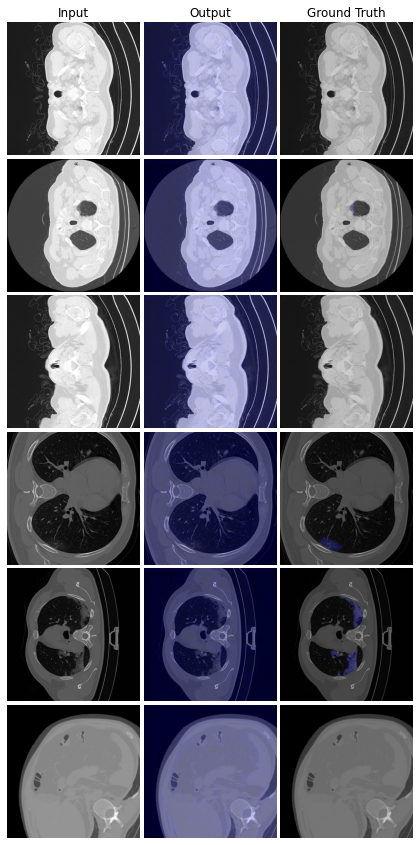

In [24]:
plot_samples(imgs, masks, figc=(10., 5.))

In [25]:
def plot_dice(train, test=None, title=None, figsize=(10, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=range(1, len(train)+1), y=train, 
                 ax=ax, label="train")
    if test is not None:
        sns.lineplot(x=range(1, len(test)+1), y=test, 
                     ax=ax, label="validation")
    ax.set_title(title)
    ax.set_xlabel("epoch")
    ax.set_ylabel("dice")
    plt.show()

In [26]:
def plot_grads(grads, title=None, figsize=(10, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=range(len(grads)), y=grads, ax=ax)
    ax.set_title(title)
    plt.show()

In [27]:
def plot_loss(train, test=None, title=None, figsize=(10, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=range(1, len(train)+1), y=train, ax=ax, label="train")
    if test is not None:
        sns.lineplot(x=range(1, len(test)+1), y=test, ax=ax, label="validation")
    ax.set_title(title)
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    plt.show()

## Training

In [28]:
LEARNING_RATE = 1e-4
EPOCHS = 100
FULL_DATASET = False
SCHEDULE_STEP = 20
SCHEDULE_GAMMA = .9

UPDATE_EVERY_N = 10
THRESHOLD = .9
# if None mean non clip, else clip by norm=CLIP_GRAD_NORM
CLIP_GRAD_NORM = 40

In [29]:
criterion = FocalTverskyLoss(.3)
optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE)
schedule = torch.optim.lr_scheduler.StepLR(
    optimizer, SCHEDULE_STEP, gamma=SCHEDULE_GAMMA) if SCHEDULE_STEP else None

In [30]:
from segmentation_models_pytorch import metrics

In [31]:
def train_model(model, train_loader, val_loader=None):
    history = {
        "train_loss":[], "val_loss":[], 
        "val_dice":[], "train_dice":[],
        "val_acc":[], "train_acc":[],
        "val_precision":[], "train_precision":[],
        "val_recall":[], "train_recall":[],
        "grads":[],
    }
    for epoch in range(1, 1+EPOCHS):
        print("epoch", epoch)
        # Train
        train_loss_sum = 0
        train_dice_sum = 0
        train_acc_sum = 0
        train_precision_sum = 0
        train_recall_sum = 0
        for i, (image, mask) in enumerate(train_loader):
            image = image.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()
            pred_mask = model(image)
            loss = criterion(pred_mask, mask)
            loss.backward()
            dice = dice_metric(pred_mask > THRESHOLD, mask)
            
            tp, fp, fn, tn = metrics.get_stats(pred_mask, mask[..., 0], "binary", threshold=THRESHOLD)
            accuracy = metrics.accuracy(tp, fp, fn, tn, reduction="micro")
            precision = metrics.precision(tp, fp, fn, tn, reduction="micro")
            recall = metrics.recall(tp, fp, fn, tn, reduction="micro")

            if CLIP_GRAD_NORM is not None:
                history["grads"].append(torch.nn.utils.clip_grad_norm_(
                    model.parameters(), CLIP_GRAD_NORM).item())

            optimizer.step()

            train_loss_sum += loss.item()
            train_dice_sum += torch.sum(dice).item()/BATCH_SIZE
            train_acc_sum += accuracy.item()
            train_precision_sum += precision.item()
            train_recall_sum += recall.item()
            

        train_mean_loss = train_loss_sum/(i+1)
        train_dice_mean = train_dice_sum/(i+1)
        train_acc_mean = train_acc_sum/(i+1)
        train_precision_mean = train_precision_sum/(i+1)
        train_recall_mean = train_recall_sum/(i+1)
        

        history["train_loss"].append(train_mean_loss)
        history["train_dice"].append(train_dice_mean)
        history["train_acc"].append(train_acc_mean)
        history["train_precision"].append(train_precision_mean)
        history["train_recall"].append(train_recall_mean)

        # Validation
        if val_loader is not None:
            with torch.no_grad():
                val_dice_sum = 0
                val_sum_loss = 0
                val_acc_sum = 0
                val_precision_sum = 0
                val_recall_sum = 0
                model.eval()
                for i, (image, mask) in enumerate(val_loader):
                    image = image.to(device)
                    mask = mask.to(device)

                    pred_mask = model(image)
                    loss = criterion(pred_mask, mask)
                    dice = dice_metric(pred_mask > THRESHOLD, mask)
                    tp, fp, fn, tn = metrics.get_stats(pred_mask, mask[..., 0], "binary", threshold=THRESHOLD)
                    accuracy = metrics.accuracy(tp, fp, fn, tn, reduction="micro")
                    precision = metrics.precision(tp, fp, fn, tn, reduction="micro")
                    recall = metrics.recall(tp, fp, fn, tn, reduction="micro")

                    val_sum_loss += loss.item()
                    val_dice_sum += torch.sum(dice).item()/BATCH_SIZE
                    val_acc_sum += accuracy.item()
                    val_precision_sum += precision.item()
                    val_recall_sum += recall.item()
                model.train()

            val_dice_mean = val_dice_sum/(i+1)
            val_mean_loss = val_sum_loss/(i+1)
            val_acc_mean = val_acc_sum/(i+1)
            val_precision_mean = val_precision_sum/(i+1)
            val_recall_mean = val_recall_sum/(i+1)

            history["val_loss"].append(val_mean_loss)
            history["val_dice"].append(val_dice_mean)
            history["val_acc"].append(val_acc_mean)
            history["val_precision"].append(val_precision_mean)
            history["val_recall"].append(val_recall_mean)

        # print log
        print("Train Dice Metric: %.4f" % train_dice_mean)
        print("Train Loss: %.4f" % train_mean_loss)
        print("Train Accuracy: %.4f" % train_acc_mean)
        print("Train Precision: %.4f" % train_precision_mean)
        print("Train Recall: %.4f" % train_recall_mean)
        
        if val_loader is not None:
            print("Validation Dice Metric: %.4f" % val_dice_mean)
            print("Validation Loss: %.4f" % val_mean_loss)
            print("Train Accuracy: %.4f" % val_acc_mean)
            print("Train Precision: %.4f" % val_precision_mean)
            print("Train Recall: %.4f" % val_recall_mean)
        if epoch%UPDATE_EVERY_N==0:
            clear_output(wait=True)
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "history": history
            }, "epoch_{}".format(epoch))
            
#             plot_grads(history["grads"])
                
            plot_loss(history["train_loss"], history["val_loss"], "Loss")
            plot_dice(history["train_dice"], history["val_dice"], "Dice Metric")
            plot_samples(imgs, masks, figc=(10., 5.), threshold=THRESHOLD)
            
        if schedule is not None:
            schedule.step()
    torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "history": history
            }, "final")
    return history
                

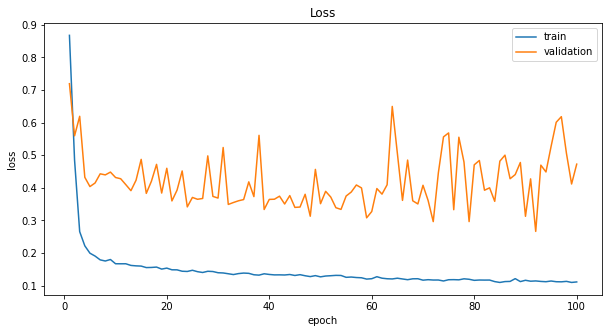

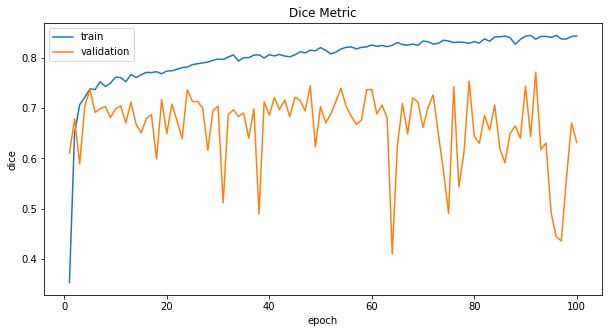

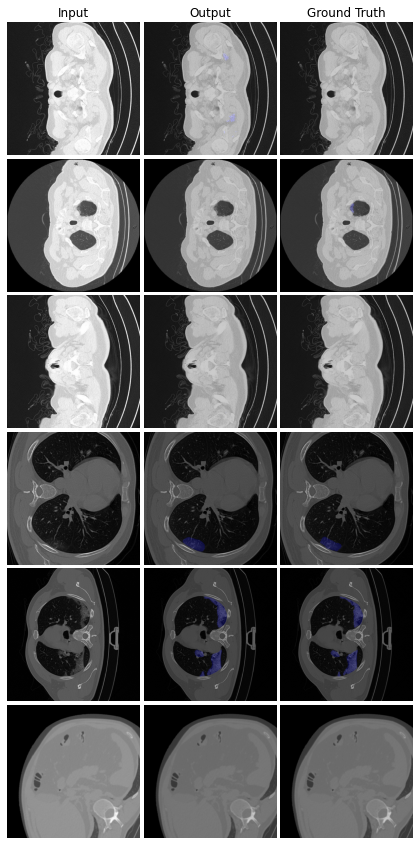

In [32]:
if not FULL_DATASET:
    history = train_model(model, dataloader_train, dataloader_test)
else:
    history = train_model(model, dataloader_full, None)

In [33]:
print("Best dice metric on train: %.4f" % max(history["train_dice"]))
print("Best loss on train: %.4f" % min(history["train_loss"]))
if len(history["val_dice"]) > 0:
    print("Best dice metric on validation: %.4f" % max(history["val_dice"]))
    print("Best loss on validation: %.4f" % min(history["val_loss"]))

Best dice metric on train: 0.8445
Best loss on train: 0.1095
Best dice metric on validation: 0.7711
Best loss on validation: 0.2661
